In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer
%matplotlib inline

In [53]:
teste = pd.read_csv('test_data.csv')
teste.shape

(951, 33)

In [50]:
# TODO: Divisão de treinamento e validação
def split_e_normaliza(df: pd.DataFrame):
  np.random.seed(42)
  X = df.drop('salario', axis=1)
  y = df['salario']
  dados_copy = X.copy()
  dados_copy['salario'] = y
  # Embaralhamento
  dados_copy = dados_copy.sample(frac=1, random_state=42).reset_index(drop=True)
  # 80% de treino
  train_size = int(0.8 * len(dados_copy))
  # Dividindo em treino e validação
  train_data = dados_copy.iloc[:train_size]
  val_data = dados_copy.iloc[train_size:]

  X_train = train_data.drop('salario', axis=1)
  y_train = train_data['salario']

  X_val = val_data.drop('salario', axis=1)
  y_val = val_data['salario']
  # normalizando
  colunas_normalizar = X_train.select_dtypes(exclude=['bool']).columns
  mean = X_train[colunas_normalizar].mean(axis=0)
  std = X_train[colunas_normalizar].std(axis=0)
  # Normalizando as colunas selecionadas nos conjuntos de treino e validação
  X_train[colunas_normalizar] = (X_train[colunas_normalizar] - mean) / std
  X_val[colunas_normalizar] = (X_val[colunas_normalizar] - mean) / std
  return X_train, y_train, X_val, y_val, mean, std

In [20]:
#TODO: Seleção de features.
# Abaixo a classe PreparaDados que aplica tudo que fizemos acima no notebook
class PreparaDados():
    def __init__(self, df, teste=False):
        """
        Realiza todas as transformações necessárias nos dados para realização da regressão linear
        Parâmetros:
        -df: dataframe a ser preparado
        -teste: flag para indicar se é para preparar o testee ou não
        """
        self.df_processado = df.copy()
        self.teste = teste
        self.colunas_remover = ['id', 'cloud_preferida', 'linguagem_preferida', 'ferramenta_bi_preferida', 'regiao_origem', 'fontes_dados_analise', 'linguagens_trabalho', 'faixa_salarial']
        if self.teste:
          self.colunas_remover = self.colunas_remover[:-1]
        self.df_processado = self.df_processado.drop(columns=self.colunas_remover, index=1)

        # Mapas para o label encoding
        self.tempo_exp_dados_map = {
            'Não tenho experiência na área de dados': 0,
            'Menos de 1 ano': 1,
            'de 1 a 2 anos': 2,
            'de 3 a 4 anos': 3,
            'de 4 a 6 anos': 4,
            'de 5 a 6 anos': 5,
            'de 7 a 10 anos': 6,
            'Mais de 10 anos': 7
        }

        self.tempo_exp_ti_map = {
            'Não tive experiência na área de TI/Engenharia de Software antes de começar a trabalhar na área de dados': 0,
            'Menos de 1 ano': 1,
            'de 1 a 2 anos': 2,
            'de 3 a 4 anos': 3,
            'de 5 a 6 anos': 4,
            'de 7 a 10 anos': 5,
            'Mais de 10 anos': 6
        }

        self.nivel_ensino_map = {
            'Prefiro não informar': 0,
            'Não tenho graduação formal': 0,
            'Estudante de Graduação': 1,
            'Graduação/Bacharelado': 2,
            'Pós-graduação': 3,
            'Mestrado': 4,
            'Doutorado ou Phd': 5
        }

        self.nivel_profissional_map = {'Júnior': 0, 'Pleno': 1, 'Sênior': 2}

        self.numero_func_map = {
            'de 1 a 5': 0,
            'de 6 a 10': 1,
            'de 11 a 50': 2,
            'de 51 a 100': 3,
            'de 101 a 500': 4,
            'de 501 a 1.000': 5,
            'de 1.001 a 3.000': 6,
            'Acima de 3.000': 7,
            'de 501 a 100': 3
        }

        # Mapeamento de regiões
        self.regioes = {
            'São Paulo (SP)': 'Sudeste', 'Minas Gerais (MG)': 'Sudeste', 'Rio de Janeiro (RJ)': 'Sudeste', 'Espírito Santo (ES)': 'Sudeste',
            'Paraná (PR)': 'Sul', 'Rio Grande do Sul (RS)': 'Sul', 'Santa Catarina (SC)': 'Sul',
            'Distrito Federal (DF)': 'Centro-Oeste', 'Goiás (GO)': 'Centro-Oeste', 'Mato Grosso (MT)': 'Centro-Oeste', 'Mato Grosso do Sul (MS)': 'Centro-Oeste',
            'Bahia (BA)': 'Nordeste', 'Pernambuco (PE)': 'Nordeste', 'Ceará (CE)': 'Nordeste', 'Paraíba (PB)': 'Nordeste', 'Rio Grande do Norte (RN)': 'Nordeste',
            'Alagoas (AL)': 'Nordeste', 'Sergipe (SE)': 'Nordeste', 'Piauí (PI)': 'Nordeste', 'Maranhão (MA)': 'Nordeste',
            'Pará (PA)': 'Norte', 'Amazonas (AM)': 'Norte', 'Tocantins (TO)': 'Norte', 'Rondônia (RO)': 'Norte', 'Amapá (AP)': 'Norte', 'Acre (AC)': 'Norte'
        }

        # Mapeamento de cargos
        self.grupo_cargos = {
            'Diretor/VP': 'Executivo',
            'Sócio ou C-level (CEO, CDO, CIO, CTO etc)': 'Executivo',
            'Gerente/Head': 'Gestor',
            'Supervisor/Coordenador': 'Gestor',
            'Team Leader/Tech Leader': 'Líder Técnico',
            'Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect': 'Engenheiro/Especialista',
            'Engenheiro de Machine Learning/ML Engineer/AI Engineer': 'Engenheiro/Especialista',
            'Analytics Engineer': 'Engenheiro/Especialista',
            'Estatístico': 'Engenheiro/Especialista',
            'DBA/Administrador de Banco de Dados': 'Engenheiro/Especialista',
            'Professor/Pesquisador': 'Acadêmico',
            'Cientista de Dados/Data Scientist': 'Profissional de Dados',
            'Analista de Negócios/Business Analyst': 'Profissional de Dados',
            'Analista de Dados/Data Analyst': 'Profissional de Dados',
            'Data Product Manager/ Product Manager (PM/APM/DPM/GPM/PO)': 'Gerente de Produto',
            'Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas': 'Desenvolvedor/Engenheiro de Software',
            'Analista de BI/BI Analyst': 'Profissional de Dados',
            'Analista de Inteligência de Mercado/Market Intelligence': 'Profissional de Dados',
            'Analista de Suporte/Analista Técnico': 'Suporte Técnico',
            'Economista': 'Outros',
            'Outras Engenharias (não inclui dev)': 'Outros',
            'Outra Opção': 'Outros'
        }
    def _exclui_colunas_20_perc(self):
        perc_faltando = (self.df_processado.isnull().sum() / len(self.df_processado)) * 100
        perc_faltando = perc_faltando.drop('linguagem_mais_usada')
        colunas_20_perc = perc_faltando[perc_faltando > 20].index
        self.df_processado = self.df_processado.drop(columns=colunas_20_perc)

    def _imputa_moda(self):
        colunas_moda = ['estado_residencia', 'area_formacao', 'mudou_estado','linguagem_mais_usada']
        for coluna in colunas_moda:
            self.df_processado[coluna].fillna(self.df_processado[coluna].mode()[0], inplace=True)

    def _remove_outliers(self):
        Q1 = self.df_processado['salario'].quantile(0.25)
        Q3 = self.df_processado['salario'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        self.df_processado = self.df_processado[(self.df_processado['salario'] >= lower_bound) & (self.df_processado['salario'] <= upper_bound)]

    def _aplica_label_encoding(self):
        # Aplicação dos mapeamentos
        self.df_processado['tempo_exp_dados'] = self.df_processado['tempo_exp_dados'].map(self.tempo_exp_dados_map)
        self.df_processado['tempo_exp_ti'] = self.df_processado['tempo_exp_ti'].map(self.tempo_exp_ti_map)
        self.df_processado['nivel_ensino'] = self.df_processado['nivel_ensino'].map(self.nivel_ensino_map)
        self.df_processado['nivel_profissional'] = self.df_processado['nivel_profissional'].map(self.nivel_profissional_map)
        self.df_processado['numero_funcionarios'] = self.df_processado['numero_funcionarios'].map(self.numero_func_map)
        self.df_processado['regiao'] = self.df_processado['estado_residencia'].map(self.regioes)
        self.df_processado.drop(columns=['estado_residencia'], inplace=True)
        self.df_processado['cargo'] = self.df_processado['cargo'].map(self.grupo_cargos)
    def _imputa_knn(self):
        # Imputação com KNN para 'nivel_profissional'
        imputer = KNNImputer(n_neighbors=3)
        self.df_processado[['nivel_profissional']] = imputer.fit_transform(self.df_processado[['nivel_profissional']])
    def _one_hot_encode(self):
        colunas_para_encode = [
            'genero', 'cor_raca', 'pcd', 'area_formacao', 'situacao_trabalho', 'setor',
            'forma_trabalho_atual', 'regiao', 'cargo', 'linguagem_mais_usada'
        ]
        self.df_processado = pd.get_dummies(self.df_processado, columns=colunas_para_encode, drop_first=True)
        self.df_processado.drop(columns=['cargo_Gestor'], inplace=True)

    def prepara_dados(self):
      self._exclui_colunas_20_perc()
      self._imputa_moda()
      if not self.teste:
        self._remove_outliers()
      self._aplica_label_encoding()
      self._imputa_knn()
      self._one_hot_encode()
      return self.df_processado

In [21]:
# TODO: Regressão Linear. Implemente sua solução. Você não pode usar bibliotecas como scikit-learn, Keras/TensorFlow, ou PyTorch.
class LinearRegression:
    def __init__(self, method='gradient_descent', learning_rate=0.01, iter_max=10000, epsilon=1e-6):
        """
        Classe para executar regressão linear multivariada.

        Parâmetros:
        - method: tipo de método para regressão(normal ou gradiente descendente).
        - learning_rate: taxa de aprendizado para o método de descida de gradiente.
        - iter_max: número máximo de iterações para descida de gradiente.
        - epsilon: limiar de convergência
        """
        self.method = method
        self.learning_rate = learning_rate
        self.iter_max = iter_max
        self.epsilon = epsilon
        self.betas = None
        self.loss_history = []

    def fit(self, X, y):
        # X é a matriz que representa os dados (m observações x n features)
        # Adiciona um termo de bias (coluna de 1's) a matriz de entrada
        X_b = np.c_[np.ones((X.shape[0], 1)), X]

        if self.method == 'gradient_descent':
            self.betas = self._gradient_descent(X_b, y)
        elif self.method == 'normal':
            self.betas = self._normal(X_b, y)
        else:
            raise ValueError("Escolha 'gradient_descent' ou 'normal'")

    def _gradient_descent(self, X, y):
        m = len(y)
        # Iniciando radomicamente
        betas = np.random.randn(X.shape[1])
        self.loss_history = []

        for i in range(self.iter_max):
            #print(f"iteration: {i}/{self.iter_max}")
            # Previsões com os betas atuais
            y_pred = X @ betas
            # Cálculo do erro
            erro = y_pred - y
            # Cálculo da função de custo (MSE)
            loss = np.mean(erro ** 2)
            self.loss_history.append(loss)
            # Gradiente: cálculo vetorizado
            gradiente = (2/m) * (X.T @ erro)
            # Atualizando os parâmetros (betas)
            betas_new = betas - self.learning_rate * gradiente

            # Critérios de convergência
            if i > 0 and abs(self.loss_history[-2] - loss) < self.epsilon:
                print(f"Convergiu com base na loss {i}")
                break
            if np.all(np.abs(betas_new - betas) < self.epsilon):
                print(f"Convergiu com base nos betas {i}")
                break

            betas = betas_new

        return betas

    def _normal(self, X, y):
        # Evita problemas de UFuncTypeError
        X = X.astype(np.float64)
        y = y.astype(np.float64)
        # Equação normal
        return np.linalg.inv(X.T @ X) @ (X.T @ y)

    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]  # Adiciona termo de bias
        return X_b @ self.betas

    def plot_loss_history(self):
      plt.plot(range(len(self.loss_history)), self.loss_history, marker='o', linestyle='-')
      plt.title('Convergência por Épocas')
      plt.xlabel('Épocas')
      plt.ylabel('Função de Custo (MSE)')
      plt.grid(True)
      plt.show()

In [49]:
def treinamento_regressao_linear(X_train, y_train, X_val, y_val, model):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_val)
  mse = mean_squared_error(y_val, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_val, y_pred)
  r2 = r2_score(y_val, y_pred)

  # Métricas
  print(f"\nMODELO: {model.method}\n")
  print(f"MSE: {mse}")
  print(f"RMSE: {rmse}")
  print(f"Mean Absolute Error (MAE): {mae}")
  print(f"R-squared (R2): {r2}")
  if model.method == 'gradient_descent':
      model.plot_loss_history()
  return y_pred

In [51]:
df_treino = pd.read_csv('train_data.csv')
prep = PreparaDados(df_treino, teste=False)
df_treino_preparado = prep.prepara_dados()
X_train, y_train, X_val, y_val, _, _ = split_e_normaliza(df_treino_preparado)

<ipython-input-20-a3ee82a447f7>:108: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.df_processado[coluna].fillna(self.df_processado[coluna].mode()[0], inplace=True)



MODELO: gradient_descent

MSE: 13895414.053783914
RMSE: 3727.6553024366285
Mean Absolute Error (MAE): 2728.4355354567087
R-squared (R2): 0.5807822474215074


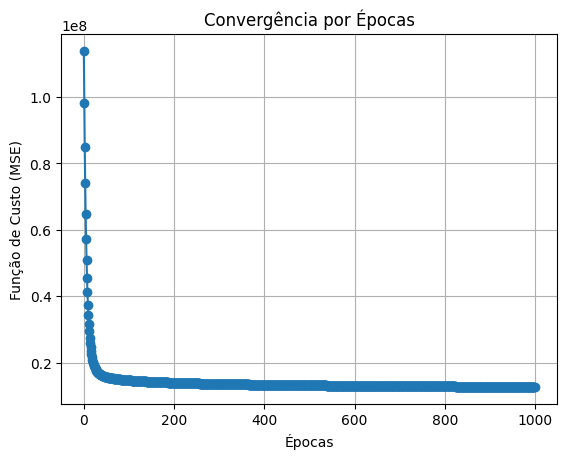


MODELO: normal

MSE: 13535956.960946366
RMSE: 3679.124482936989
Mean Absolute Error (MAE): 2702.612819404918
R-squared (R2): 0.5916268896915751


In [52]:
model_gd = LinearRegression(method='gradient_descent', learning_rate=0.01, iter_max=1000, epsilon=1e-6)
model_normal = LinearRegression(method='normal')
y_pred_gd = treinamento_regressao_linear(X_train, y_train, X_val, y_val, model_gd)
y_pred_normal = treinamento_regressao_linear(X_train, y_train, X_val, y_val, model_normal)

TESTE